# Chapter 4 - Testing

First import the required modules (with abbreviated names).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from util import myfigure        # plotting routine from Steven

In [2]:
# Define the solution function, u(x,t;lam).
def uxt(x,t,lam):
    X = np.array(3*np.sin(np.pi*x) + np.sin(3*np.pi*x))
    T = np.array(np.exp(-lam * math.pow(np.pi,2) * t))
    return np.outer(T, X)

In [3]:
# Data components (in dictionary).


# Time. 
ip_data = {
    'T': 0.05,  # final time
    'nt': 3     # number of temporal measurements
}
ip_data['t_obs'] = ip_data['T']*np.arange(1,ip_data['nt']+1)/ip_data['nt']   # measurement times


# Space
ip_data['nx'] = 4                                                   # number of spatial measurements
ip_data['x_obs'] = np.arange(1,ip_data['nx']+1)/(1+ip_data['nx'])   # observation locations


# Spatial locations (plotting).
x = np.linspace(0,1,50)


# True observations.
ip_data['lam'] = 5*np.pi/3                                                     # thermal conductivity
ip_data['G'] = uxt(ip_data['x_obs'],ip_data['t_obs'],ip_data['lam']).ravel()   # true obs
ip_data['nd'] = ip_data['nx']*ip_data['nt']                                    # number of obs


# Noise.
ip_data['seed'] = 0                                                           # seed RNG
np.random.seed(0)
ip_data['noise_ratio'] = 5/100                                                    # 5% signal-noise ratio
ip_data['sig_rho'] = np.sqrt(ip_data['noise_ratio'] * np.mean(ip_data['G']))      # noise std
ip_data['rho_noise'] = np.random.normal(0,ip_data['sig_rho'],(ip_data['nd'],1)).ravel()   # noise value


# Noisy data.
ip_data['d'] = ip_data['G'] + ip_data['rho_noise']


# Print dictionary to screen.
for key in ip_data:
    print(key, ip_data[key])

T 0.05
nt 3
t_obs [0.01666667 0.03333333 0.05      ]
nx 4
x_obs [0.2 0.4 0.6 0.8]
lam 5.235987755982989
G [1.14716077 0.95739325 0.95739325 1.14716077 0.48481133 0.40461207
 0.40461207 0.48481133 0.20489022 0.17099654 0.17099654 0.20489022]
nd 12
seed 0
noise_ratio 0.05
sig_rho 0.16757744938182473
rho_noise [ 0.29561539  0.06705732  0.16401441  0.37552317  0.3129606  -0.16376973
  0.15921339 -0.02536405 -0.01729715  0.06880705  0.02413845  0.24370345]
d [1.44277616 1.02445058 1.12140767 1.52268394 0.79777194 0.24084234
 0.56382547 0.45944728 0.18759307 0.23980359 0.19513499 0.44859367]


[0, 1, 0, 3]

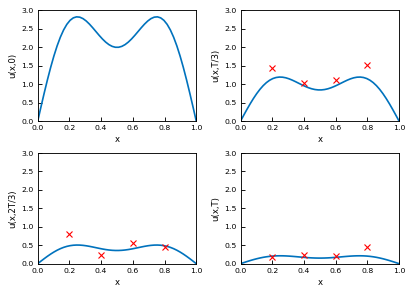

In [4]:
# Plot data (seperate commands)


# Matrix representation of noisy data.
d_mat = np.reshape(ip_data["d"],(ip_data["nt"],ip_data["nx"]))


# Subplot routine.
fig, (ax1, ax2, ax3, ax4) = myfigure(nrows=2, ncols=2)

ax1.plot(x, np.squeeze(uxt(x,0,ip_data['lam'])))
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,0)')    
ax1.axis([0, 1, 0, 3])

ax2.plot(x, np.squeeze(uxt(x,ip_data['t_obs'][0],ip_data['lam'])))
ax2.plot(ip_data['x_obs'], d_mat[0,:], 'xr')
ax2.set_xlabel('x')
ax2.set_ylabel('u(x,T/3)')    
ax2.axis([0, 1, 0, 3])

ax3.plot(x, np.squeeze(uxt(x,ip_data['t_obs'][1],ip_data['lam'])))
ax3.plot(ip_data['x_obs'], d_mat[1,:], 'xr')
ax3.set_xlabel('x')
ax3.set_ylabel('u(x,2T/3)')    
ax3.axis([0, 1, 0, 3])

ax4.plot(x, np.squeeze(uxt(x,ip_data['t_obs'][2],ip_data['lam'])))
ax4.plot(ip_data['x_obs'], d_mat[2,:], 'xr')
ax4.set_xlabel('x')
ax4.set_ylabel('u(x,T)')    
ax4.axis([0, 1, 0, 3])

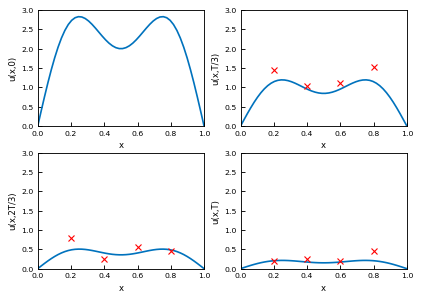

In [5]:
# Labels for y-axes.
ylabs = ['u(x,0)', 'u(x,T/3)','u(x,2T/3)','u(x,T)']

# Subplot routine from Steven.
fig, ax = myfigure(nrows=2, ncols=2)


for i,axi in enumerate(ax):
    
    if i == 0:
        # Initial data.
        axi.plot(x, np.squeeze(uxt(x,0,ip_data['lam'])))
    else:
        # Measurement times data.
        axi.plot(x, np.squeeze(uxt(x,ip_data['t_obs'][i-1],ip_data['lam'])))
        axi.plot(ip_data['x_obs'], d_mat[i-1,:], 'xr')
        
    axi.set_xlabel('x')
    axi.set_ylabel(ylabs[i])    
    axi.axis([0, 1, 0, 3])

plt.savefig('test.pdf', dpi=300)

In [6]:
# Function to convert (mu,sigma) [Normal] to (m,s) [logNorm].
# Y = exp(X): X~N(m,s^2); Y~logN(mu,sigma^2)

def m_s_from_mu_sig(mu,sig):

    c = 1 + np.power(sig/mu,2) # constant
    
    m = np.log(mu/np.sqrt(c))
    s = np.sqrt(np.log(c))
    
    return m,s

In [7]:
from scipy.stats import uniform as Unif
from scipy.stats import norm as Norm
from scipy.stats import multivariate_normal as mvNorm


# Posterior
def posterior(theta, prior, ip_data):
    
    # Prior density.
    if prior[0] == "unif":
        p0 = Unif.pdf(theta, prior[1], prior[2]-prior[1])  # Uniform pdf
    elif prior[0] == "normal":
        p0 = Norm.pdf(theta, prior[1], prior[2]) # Gaussian pdf

    
    # Forward evaluation.
    F = uxt(ip_data['x_obs'], ip_data['t_obs'], np.exp(theta)).ravel()
    
    
    # Evaluate likelihood (multivariate Normal).
    L = mvNorm.pdf(F, ip_data['d'], ip_data['sig_rho'])

    
    # Return evaluation of the posterior., prior and likelihood.
    return p0*L, p0, L





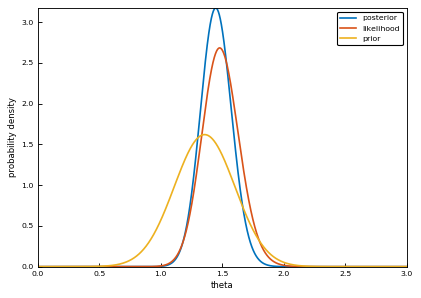

In [8]:
# Test the posterior by plotting it.

Nt = 5000   # number of evaluation points

tv = np.linspace(0,3, Nt) # theta values
p0 = np.zeros(Nt)     # prior evaluations
Lv = np.zeros(Nt)     # likelihood evaluations


# Prior parameters
m, s = m_s_from_mu_sig(4,1)
prior = ["normal", m, s]


for n in range(Nt):
    dummy_var, p0[n], Lv[n] = posterior(tv[n], prior, ip_data)
    
    
# Posterior evaluations
pv = p0*Lv


# Normalise.
p0 = p0/np.trapz(p0,tv)
Lv = Lv/np.trapz(Lv,tv)
pv = pv/np.trapz(pv,tv)


# Plot.
fig, ax = myfigure()

ax.plot(tv, pv, label='posterior')
ax.plot(tv, Lv, label='likelihood')
ax.plot(tv, p0, label='prior')
ax.set_xlabel('theta')
ax.set_ylabel('probability density')    
leg = ax.legend();


In [17]:
# MCMC Routine

NB = int(1e3)  # no. burn in samples
N = int(2e4)   # no samples

nbins = 100  # number of histogram bins

sig_q = 5.5e-1  # proposal standard deviation



# MCMC Sampling
tvec = np.zeros(N+NB)  # storage for samples values of theta
count = 0 # counter for number of accepted samples

# Initial state
tvec[0] = np.log(ip_data['lam'])  # true value


# Evaluate posterior at true state.
post, dummy1, dummy2 = posterior(tvec[0],prior,ip_data)


# Monte Carlo loop
for n in range(NB+N-1):
    
    t_p = Norm.rvs(tvec[n],sig_q)  # proposal value
    
    post_p, dummy1, dummy2 = posterior(t_p, prior, ip_data) # evaluate posterior at proposal

    alpha = min(1, post_p/post)  # acceptance probability
    
    z = Unif.rvs()
    
    if z < alpha:
        # accept
        tvec[n+1] = t_p
        post = post_p
        
        if n > NB:
            count = count + 1
            
    else:
        # reject
        tvec[n+1] = tvec[n]
        
        
    # Output progress to screen
    if n > NB:
        if round(10*n/N) > round(10*(n-1)/N):
    #        print("Progress: " + str(n) + "/" str(N) + " samples computed, " + str(round(100*n/N)) + "% complete.")
            print(n)        

# Proportion of proposals accepted.            
prop = count/N



1001
3000
5001
7000
9001
11000
13001
15000
17001
19000


0.2708
[1.36569072 1.43709102 1.62607265 1.62607265 1.62607265 1.62607265
 1.41293565 1.42395818 1.42395818 1.42395818 1.42395818 1.42395818
 1.42395818 1.42395818 1.42395818 1.42395818 1.42395818 1.42395818
 1.42395818 1.42395818]


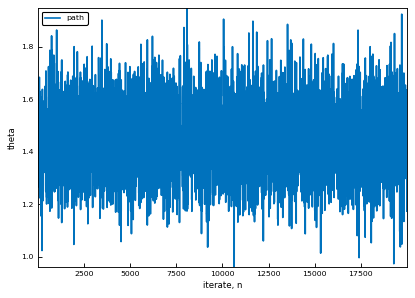

In [18]:
print(prop)

print(tvec[NB:NB+20])

chain = tvec[NB+1:]

#len(chain)
len(range(1,N+1))


# Plot
fig, ax = myfigure()

ax.plot(range(1,N), chain, label='path')
ax.set_xlabel('iterate, n')
ax.set_ylabel('theta')    
leg = ax.legend();

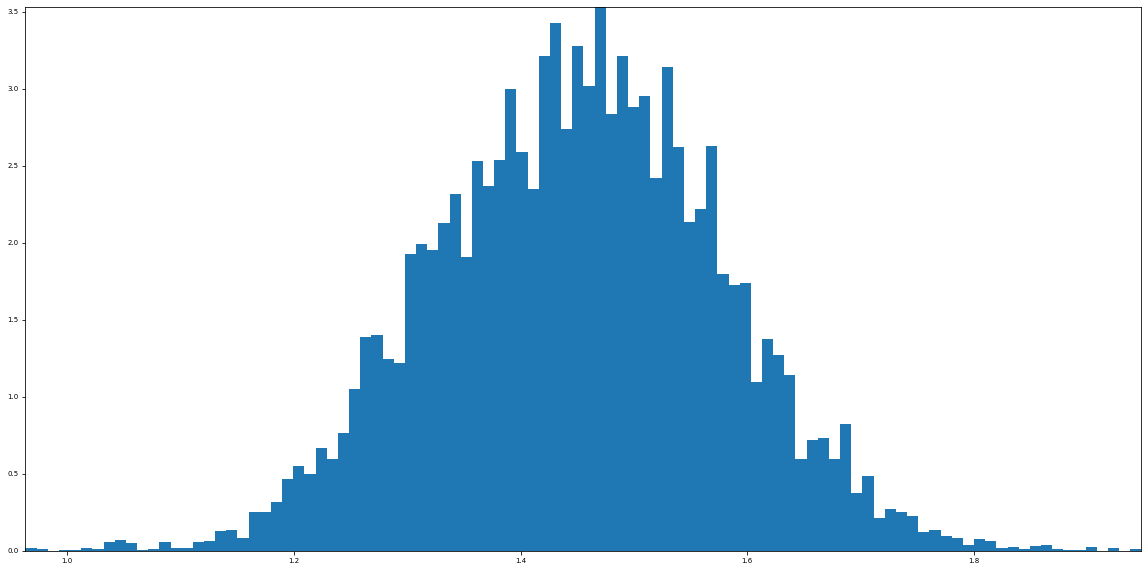

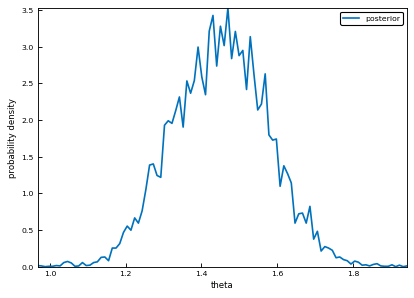

In [20]:
# Histogram results


# 
hist, bin_edges = np.histogram(chain, 100, density=1)

bin_centres = (bin_edges[1:] + bin_edges[:-1])/2

#print(bin_edges)
#print(bin_centres)

# Plot histogram (inbuilt function)
plt.hist(chain, bins=100, density=1)


# Plot histogram manually.
fig, ax = myfigure()

ax.plot(bin_centres, hist, label='posterior')
ax.set_xlabel('theta')
ax.set_ylabel('probability density')    
leg = ax.legend();


In [12]:
for i in range(1,4):
    print(i)

1
2
3


In [13]:
x = [1,2,3,4,5,6]
print(x[1:])

print(np.arange(1,4))

y = x[3:]
print(y)

print(2/1)

[2, 3, 4, 5, 6]
[1 2 3]
[4, 5, 6]
2.0
